# **Network Analysis**

Consider the Manufacturing Email data1, which is given in the following format: each row "a b t" denotes
a contact (a temporal link) between node a and b at time step t. This contact network is sampled/measured
once every 1 second. Thus, each time step has a duration of 1s, which is though not relevant for our analysis in
this assignment. We denote this temporal network as Gdata.

A. Explore properties of network G that is aggregated over all the T = 57791 steps. Specifically, the
aggregated network G is composed of all the nodes that have ever appeared in the dataset and any two nodes
are connected by a link if they have at least a contact over the whole period [0,T].

Compute the following topological properties of G in 1-7 without considering the weight of any link and
the link weight property in 8.

In [4]:
import networkx as nx
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import seaborn as sns

In [5]:
file_location = r'/content/manufacturing_emails_temporal_network.xlsx'
raw_data = pd.read_excel(file_location)

G = nx.convert_matrix.from_pandas_edgelist(raw_data, source = 'node1', target = 'node2')
print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 167
Number of edges: 3250
Average degree:  38.9222


Question 1 - What is the number of nodes N, the number of links L, the average degree E[D] and standard deviation
of the degree

In [7]:
 #average degree
np.mean(np.asarray(list(dict(G.degree()).values())))

38.92215568862275

In [9]:
#standard deviation of degree
np.std(np.asarray(list(dict(G.degree()).values())))

31.52529523516606

Question 2 - Plot the degree distribution. Which network model, Erdos-Renyi (ER) random graphs or scale-free
networks, could better model this network? Why?

Text(0, 0.5, 'Frequency')

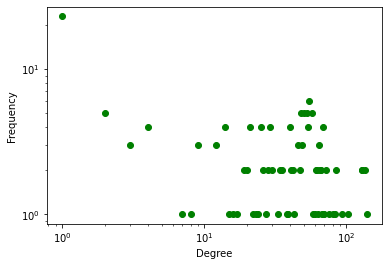

In [11]:
plt.loglog(degrees[:], degree_freq[:],'go-',linestyle = 'None')
plt.xlabel('Degree')
plt.ylabel('Frequency')

Scale Free due to power law distribution

Question 3 - What is the degree correlation (assortativity) ?


In [ ]:
nx.degree_assortativity_coefficient(G)

-0.29517729789301855

Question 4 - What is the clustering coecient C?

In [ ]:
nx.average_clustering(G)

0.5918632085486949

Question 5 - What is the average hopcount E[H] of the shortest paths between all node pairs? What is the diameter?

In [ ]:
nx.average_shortest_path_length(G)

1.9673905201644903

In [ ]:
nx.diameter(G)

5

Question 6 - Does this network have the small-world property? 

In [ ]:
G_random = nx.gnm_random_graph(len(G.nodes()), len(G.edges()))

In [ ]:
print(nx.average_clustering(G_random))
print(nx.average_shortest_path_length(G_random))


0.23452760127763472
1.7656013274655509


Average hopcount is comparable and clustering coefficient is much higher (double). So it is a small world network

Question 7 - What is the largest eigenvalue (spectral radius) of the adjacency matrix?

In [ ]:
adj_mat = nx.adjacency_matrix(G)
np_adj = scipy.sparse.csr_matrix.toarray(adj_mat)
np.max(np.linalg.eig(np_adj)[0])

(60.63926551053451+0j)

Question 8 - Consider further the weight of each link in G, which is the total number of contacts between the corre-
sponding two nodes within [0,T]. Plot the distribution of all the link weights (Choose the scales of the two axes
and the bins/bin-size for the distribution such that the plot is insightful for interpretation). Does it follow a
power-law distribution? Why?

In [12]:
raw_data_timeless = raw_data[['node1','node2']]
df = raw_data_timeless.groupby(['node1','node2']).size()
grouped_weight = pd.DataFrame(df).reset_index()
grouped_weight.columns = ['node1','node2','weight']
weighted_graph = nx.from_pandas_edgelist(grouped_weight,source='node1',target='node2',edge_attr='weight')

weights_dist = grouped_weight['weight'].sort_values(ascending=False)
weight_range = range(len(weights_dist))
weights_dist.head()

grouped_weight

,node1,node2,weight
0,1,2,98
1,1,3,98
2,1,4,125
3,1,5,90
4,1,6,175
...,...,...,...
3245,117,151,3
3246,121,124,4
3247,122,140,58
3248,136,155,1


Text(0, 0.5, 'Frequency')

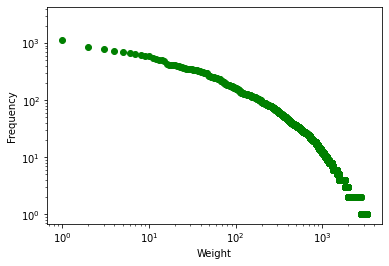

In [13]:
plt.figure(figsize=(6, 4)) 

plt.loglog(weight_range[:], weights_dist[:],'go-',linestyle = 'None')
plt.xlabel('Weight')
plt.ylabel('Frequency')

#Follows Power Law

# **B. Information spreading on a temporal network**
We consider the following information spreading process, which is actually a simplified Susceptible-Infected
model but on a temporal network. Initially, at time t = 0, a single node s is infected meaning that this
node possesses the information whereas all the other nodes are Susceptible, thus have not yet perceived the
information. Nodes is also called the seed of the information. Whenever an infected node i is in contact with
a susceptible node j at any time step t, the susceptible node becomes infected during the same time step and
could possibly infect other nodes only since the next time step via its contacts with susceptible nodes. Once a
node becomes infected, it stays infected forever. For example, assume that the seed node has its first contact at
time t = 5 and that contact is with node m. Although node s gets infected since t = 0, it infects a second node,
i.e. node m only at t = 5 when it contacts m. Infection happens only when an infected node and a susceptible
node are in contact. The number of infected nodes is non-decreasing over time.

Simulate the information spreading process on the given temporal network Gdata for N iterations. Each
iteration starts with a dierent seed node infected at t = 0 and ends at t = T = 57791 the last time step that
the network is measured. Via the N iterations, we consider the spreading process that starts at every node
i in [1,N]. Record the number of infected nodes I(t) over time t for each iteration.

In [ ]:
raw_data_infected = raw_data

In [ ]:
# A very inefficient implementation
def infection_simulation(G):
  dict_values = dict()
  for g in list(G.nodes()):
    infected = g
    infected_list = []
    infected_list.append(infected)
    print("Starting infected Node",g)

    dict_timestamps = dict()
    for t in raw_data_infected['timestamp'].unique():
      temp_raw = raw_data_infected.loc[raw_data_infected['timestamp'] == t]
      temp_G = nx.from_pandas_edgelist(temp_raw[['node1','node2']],source='node1',target='node2')

      for n in temp_G.nodes():
        if n in infected_list:
          reinfect_list = list(temp_G.neighbors(n))
          infected_list.extend(reinfect_list)
          infected_list = list(dict.fromkeys(infected_list))

        dict_timestamps[t] = len(infected_list)

      dict_values[g] = dict_timestamps

  df = pd.DataFrame.from_dict(dict_values)
  df = df.reset_index(drop=True)
  return df

In [ ]:
dfB = infection_simulation(G)
dfB.to_csv('partBG1.csv',index = False)

In [ ]:
dfB = pd.read_csv('/content/partBG1.csv')

Question 9 - Taking all the N iterations into count, plot the average number of infected nodes E[I(t)] together with
its error bar (standard deviation) as a function of the time step t.

In [ ]:
dfB_mean = dfB.mean(axis=1)
dfB_std = dfB.std(axis=1)
x_axis = range(len(dfB_mean))

(0.0, 60.0)

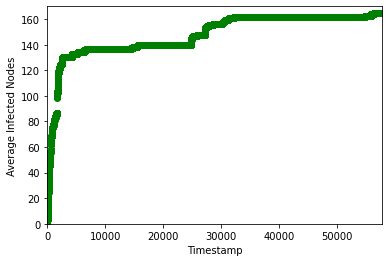

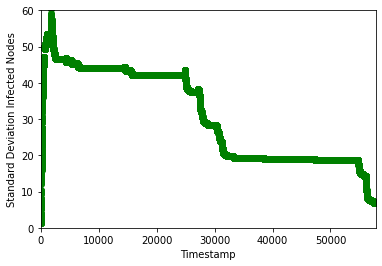

In [ ]:
plt.figure(figsize=(6, 4)) 
plt.plot(x_axis[:], dfB_mean[:],'go-',linestyle = 'None')
plt.xlabel('Timestamp')
plt.ylabel('Average Infected Nodes')

axes = plt.gca()
axes.set_xlim([0,57791])
axes.set_ylim([0,170])

plt.figure()
plt.plot(x_axis[:], dfB_std[:],'go-',linestyle = 'None')
plt.xlabel('Timestamp')
plt.ylabel('Standard Deviation Infected Nodes')

axes = plt.gca()
axes.set_xlim([0,57791])
axes.set_ylim([0,60])

<ErrorbarContainer object of 3 artists>

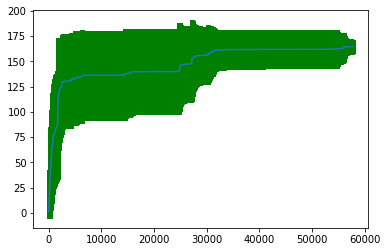

In [ ]:
plt.errorbar(x_axis[:],dfB_mean[:],yerr = dfB_std[:],ecolor='g',elinewidth=5,mec='green',mfc='red')

Question 10 - How influential a node is as a seed node could be partially reflected by the time it takes to reach/infect
80% of the total nodes when this node is selected as the seed node. The shorter the time is, the more influential
the seed node is. Using this standard to rank the in
uence of all the nodes and record the ranking in a vector
R = [R(1),R(2),...,R(N)] where R(i) is the node index of the i-th most influential seed node and R(1) is the
most influential node that infects 80% nodes in the shortest time.

In [14]:
threshold = math.ceil(0.8*len(list(G.nodes())))
threshold

134

In [ ]:
r_values = dict()
for c in dfB.columns.to_list():
    try:
        r_values[c] = dfB.index[dfB[c]>=threshold].to_list()[0] + 1
    except:
        r_values[c] = dfB.index[dfB[c]==dfB[c].max()].to_list()[-1] + 1

In [ ]:
sorted_r = dict(sorted(r_values.items(), key=lambda item: item[1]))

Question 11 - We are going to explore which nodal level network feature in the aggregated network G could well suggest
the nodal influence discussed in 10). Compute the degree and strength2 of each node in the aggregated network
G and rank the importance of the nodes according to these two centrality metrics respectively. You obtain the
ordered vector D = [D(1);D(2),...,D(N)] and S = [S(1); S(2),...,S(N)], where D(i) is the node having the ith
highest degree and S(i) is the node with the ith highest strength. How precisely a centrality metric e.g. the
degree could predict seed nodes' influence could be quantified by the top f recognition rate rRD(f) = |Rf & Df| /
|Rf| where Rf and Df are the sets of nodes ranking in the top f fraction according to their influence and degree
respectively and |Rf| = fN is the number of nodes in Rf . Plot rRD(f) and rRS(f) as a function of f where
f = 0:05, 0:1, 0:15,..., 0:5. Which metric, the degree or the strength could better predict the influence of the nodes? 

In [ ]:
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = dict(sorted(degree_dict.items(), key=lambda item: item[1],reverse=True))

In [ ]:
strength = grouped_weight.groupby('node1').sum().reset_index().drop(['node2'],axis=1).sort_values('weight',ascending=False)
strength_dict = pd.Series(strength.weight.values,index=strength.node1).to_dict()

In [ ]:
def recognition_rate(infection_metric, graph_metric):
  result = []
  for i in np.arange(0.05, 0.55, 0.05):
    f = round(i*len(infection_metric))
    result.append(len(set(infection_metric[:f]) & set(list(graph_metric.keys())[:f]))/len(infection_metric[:f]))
  return result

In [ ]:
r_RD = recognition_rate(r_list_int, sorted_degree)

In [ ]:
r_RS = recognition_rate(r_list_int, strength_dict)

<Figure size 432x288 with 0 Axes>

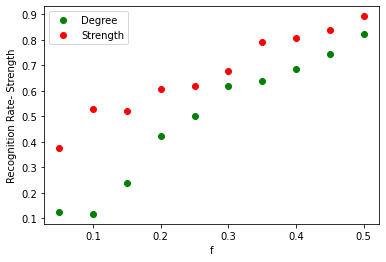

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 4)) 
plt.plot(np.arange(0.05, 0.55, 0.05)[:], r_RD[:],'go-',linestyle = 'None',label = 'Degree')
plt.xlabel('f')
plt.ylabel('Recognition Rate')

plt.plot(np.arange(0.05, 0.55, 0.05)[:], r_RS[:],'ro-',linestyle = 'None',label = 'Strength')
plt.xlabel('f')
plt.ylabel('Recognition Rate')
plt.legend()
plt.figure()

Question 12 - Propose another two nodal/centrality features that could possibly well predict nodes' influence. The
previous two features are all based on the aggregated network. At least one feature that you are going to
propose should take nodal temporal features into account. Compare the two features you proposed and the two
features proposed in question 11): which feature better/badly reflects how influential a node is and why?

In [ ]:
centrality_dict = dict(nx.betweenness_centrality(G))
centrality_dict = dict(sorted(centrality_dict.items(), key=lambda item: item[1],reverse=True))

In [ ]:
r_RB = recognition_rate(r_list_int, centrality_dict)

In [ ]:
# Time based metric - Average degree with time
dict_cent = {k: [] for k in range(1,168)}

for t in raw_data['timestamp'].unique():
    temp_raw = raw_data.loc[raw_data['timestamp'] == t]
    print("Timestamp",t)
    temp_G = nx.from_pandas_edgelist(temp_raw[['node1','node2']],source='node1',target='node2')
    for g in temp_G.nodes():

      deg = temp_G.degree[g]

      dict_cent[g].append(deg)

print(dict_cent)

In [ ]:
dict_avg_degree_time = dict_cent.copy()
for i in dict_avg_degree_time.keys():
  dict_avg_degree_time[i] = round(sum(dict_avg_degree_time[i])/len(dict_avg_degree_time[i]),4) 


In [ ]:
dict_avg_degree_time = dict(sorted(dict_avg_degree_time.items(), key=lambda item: item[1],reverse=True))

In [ ]:
r_RC = recognition_rate(r_list_int, dict_avg_degree_time)

<Figure size 432x288 with 0 Axes>

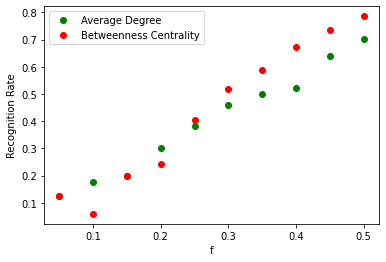

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 4)) 
plt.plot(np.arange(0.05, 0.55, 0.05)[:], r_RC[:],'go-',linestyle = 'None',label = 'Average Degree through time')
plt.xlabel('f')
plt.ylabel('Recognition Rate')
plt.plot(np.arange(0.05, 0.55, 0.05)[:], r_RB[:],'ro-',linestyle = 'None',label = 'Betweenness Centrality')
plt.xlabel('f')
plt.ylabel('Recognition Rate')
plt.legend()
plt.figure()

Question 13 - How in
uential a node is as a seed node can be also re
ected by the average time for the information
started by this seed at t = 0 to reach a node that belongs to the set M of 80%  N nodes that are reached
earliest in time. Use this standard to rank the in
uence of all the nodes and record the ranking in a vector
R0 = [R0(1), R0(2),..., R0(N)]. Which metric, R, the degree or the strength, could better predict the influence
ranking R0 ? Hint: use the method proposed in 11), Influence standard in 13) considers the average time to
infect a node in M whereas the influence standard in 10) considers the maximal time to infect a node in M.

In [ ]:
# A more efficient implementation which can be used an alternate template for def infection_simulation()

dict1 = {n: {x: False for x in range(1,G.number_of_nodes()+1)} for n in range(1,G.number_of_nodes()) }
dict2 = {n: {y: 57791 for y in range(1, G.number_of_nodes())} for n in range(1,G.number_of_nodes()) }
dict3 = dict()
print(dict1)
print(dict2)
for n in range (1,G.number_of_nodes()):
  print("Node ",n)
  dict1[n][n] = True

  for index, row in raw_data.iterrows():

    if dict1[n][row['node1']] == True:

      if dict1[n][row['node2']] == False:

        dict1[n][row['node2']] = True

        dict2[n][row['node2']] = row['timestamp']


    elif dict1[n][row['node2']] == True:
      if dict1[n][row['node1']] == False:
        dict1[n][row['node1']] = True

        dict2[n][row['node1']] = row['timestamp']

  dict2[n].pop(n)
  dict3[n] = np.mean(list(dict2[n].values()))

In [ ]:
dict_Rp = dict3.copy()
Rp_nodes = sorted(dict_Rp, key=dict_Rp.get,reverse=False)

In [ ]:
rp_RD = recognition_rate(Rp_nodes, sorted_degree)

In [ ]:
rp_RS = recognition_rate(Rp_nodes, strength_dict)

In [ ]:
rp_R = recognition_rate(Rp_nodes, sorted_r)

[1.0, 0.7647058823529411, 0.76, 0.7575757575757576, 0.7380952380952381, 0.84, 0.8620689655172413, 0.8656716417910447, 0.9466666666666667, 0.9404761904761905]


<Figure size 432x288 with 0 Axes>

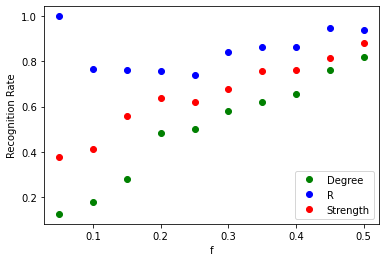

<Figure size 432x288 with 0 Axes>

In [ ]:
x_range = np.arange(0.05, 0.55, 0.05)
plt.figure(figsize=(6, 4)) 
plt.plot(x_range[:], rp_RD[:],'go-',linestyle = 'None',label = 'Degree')
plt.xlabel('f')
plt.ylabel('Recognition Rate')


print(rp_R)
plt.plot(x_range[:], rp_R[:],'bo-',linestyle = 'None',label = 'R')
plt.xlabel('f')
plt.ylabel('Recognition Rate')



plt.plot(x_range[:], rp_RS[:],'ro-',linestyle = 'None',label = 'Strength')
plt.xlabel('f')
plt.ylabel('Recognition Rate')
plt.legend()


plt.figure()

# **Part C - Influence of temporal network features on information spreading.**

Question 14 - Construct the following three temporal networks. G2 is exactly the same as Gdata except that the timestamps describing when each temporal link (contact) appears in Gdata are randomised in G2. In other words,
G2 is constructed by copying all the temporal links {(a,b,t)} from Gdata but their time stamps t are randomly
re-shuffled. The number of contacts between each node pair is the same between Gdata and G2. [A time stamp
vector v, whose length equals the number of contacts, can be randomly reshuffled to a vector v2 of the same
length by assigning each element in v to a randomly selected position in vector v2 while avoiding more than
one elements from v assigned to the same position in v2]. G3 is constructed by the following steps: G3
has the same topology as G, which is an unweighted network. Secondly, assign the time stamps in Gdata to the links in
G3 randomly. A link in G3
may receive more than one time stamps, meaning that the two nodes contact more
than once. A link in G3
receives no time stamp means that there is no contact between the corresponding two
nodes. G3 is a temporal network composed of all these contacts and has the same number of contacts as Gdata

In [ ]:
raw_data_timeless = raw_data[['node1','node2']]
df_grouped = raw_data_timeless.groupby(['node1','node2']).size()
pairs = pd.DataFrame(df_grouped).reset_index()
pairs.columns = ['node1','node2','weight']
pairs = pairs.drop(['weight'],axis=1)

In [ ]:
def inter_arrival_times(edgewiseData, raw_data):
  total_time_diff = []
  for i in range(len(edgewiseData)):
    n1 = edgewiseData.iloc[0]['node1']
    n2 = edgewiseData.iloc[0]['node2']
    time = list(raw_data.loc[(raw_data['node1'] == n1) & (raw_data['node2'] == n2)]['timestamp'].unique())
    time_diff = [x - time[i - 1] for i, x in enumerate(time) if i > 0]
    total_time_diff.extend(time_diff)


In [ ]:
total_time_diff_G1 = inter_arrival_times(pairs, raw_data.copy())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


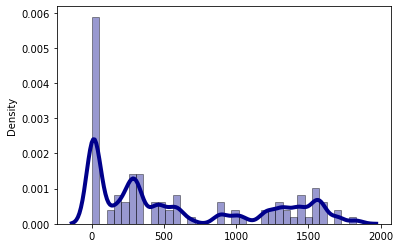

In [ ]:
sns.distplot(sorted(total_time_diff_G1), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Creating G2 and calculating the inter-arrival times

In [ ]:
data=raw_data.copy()
data['timestamp'] = np.random.permutation(raw_data['timestamp'].values)

In [ ]:
g2_raw = data[['node1','node2','timestamp']]
g2_raw = g2_raw.sort_values(by=['timestamp','node1']).reset_index().drop(['index'],axis=1)

In [ ]:
raw_data_timeless = g2_raw[['node1','node2']]
df_grouped = raw_data_timeless.groupby(['node1','node2']).size()
pairs_G2 = pd.DataFrame(df_grouped).reset_index()
pairs_G2.columns = ['node1','node2','weight']
pairs_G2 = pairs_G2.drop(['weight'],axis=1)

In [ ]:
total_time_diff_G2 = inter_arrival_times(pairs_G2, g2_raw.copy())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


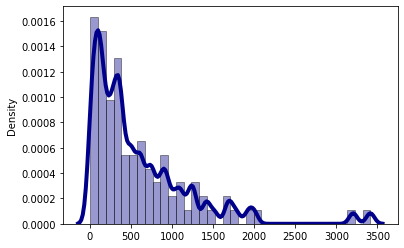

In [ ]:
sns.distplot(sorted(total_time_diff_G2), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Creating G3 and calculating the inter-arrival times

In [ ]:
g3_raw = raw_data.copy()
g3_raw['timestamp'] = np.random.randint(low = 1, high = 57791, size = (len(raw_data),1))
g3_raw = g3_raw.sort_values(by=['timestamp','node1']).reset_index().drop(['index'],axis=1)

In [ ]:
raw_data_timeless = g3_raw[['node1','node2']]
df_grouped = raw_data_timeless.groupby(['node1','node2']).size()
pairs_G3 = pd.DataFrame(df_grouped).reset_index()
pairs_G3.columns = ['node1','node2','weight']
pairs_G3 = pairs_G3.drop(['weight'],axis=1)

In [ ]:
total_time_diff_G3 = inter_arrival_times(pairs_G3, g3_raw.copy())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


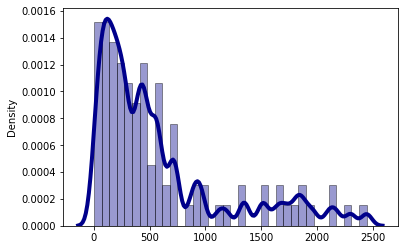

In [ ]:
sns.distplot(sorted(total_time_diff_G3), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Question 15 - Simulate exactly the same information spreading process on G2 and G3 as described in B. On each
temporal network, N iterations of the spreading processes are simulated and each iteration starts at a dierent
seed node. Plot the average number of infected nodes E[I(t)] and the standard deviation as a
function of the time step t for Gdata, G2 and G3 respectively. Compare and rank the information spreading
performance (e.g. prevalence or speed of the spread) on these three temporal networks. Interpret/explain your
observation. E.g. which temporal network features could possibly explain the different spreading performance?

In [ ]:
G2 = nx.convert_matrix.from_pandas_edgelist(g2_raw, source = 'node1', target = 'node2')
dfG2 = infection_simulation(G2)
dfG2_mean = dfG2.mean(axis=1)
dfG2_std = dfG2.std(axis=1)
x_axis = range(len(dfG2_mean))

(0.0, 60.0)

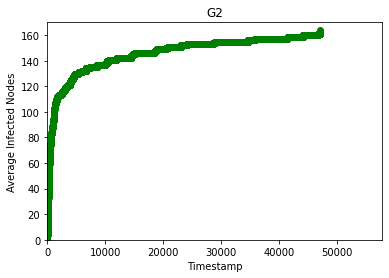

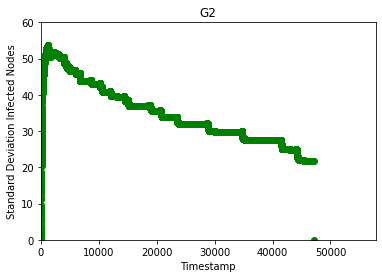

In [ ]:
plt.figure(figsize=(6, 4)) 
plt.plot(x_axis[:], dfG2_mean[:],'go-',linestyle = 'None')
plt.xlabel('Timestamp')
plt.ylabel('Average Infected Nodes')
plt.title("G2")

axes = plt.gca()
axes.set_xlim([0,57791])
axes.set_ylim([0,170])

plt.figure()
plt.plot(x_axis[:], dfG2_std[:],'go-',linestyle = 'None')
plt.xlabel('Timestamp')
plt.ylabel('Standard Deviation Infected Nodes')
plt.title("G2")

axes = plt.gca()
axes.set_xlim([0,57791])
axes.set_ylim([0,60])

(0.0, 60.0)

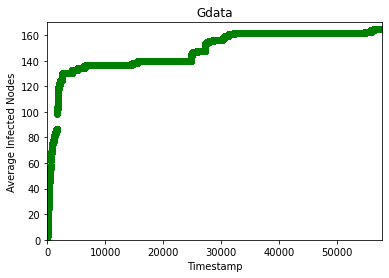

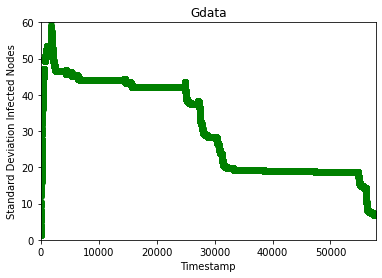

In [ ]:
plt.figure(figsize=(6, 4)) 
plt.plot(x_axis[:], dfB_mean[:],'go-',linestyle = 'None')
plt.xlabel('Timestamp')
plt.ylabel('Average Infected Nodes')
plt.title("Gdata")

axes = plt.gca()
axes.set_xlim([0,57791])
axes.set_ylim([0,170])


plt.figure()
plt.plot(x_axis[:], dfB_std[:],'go-',linestyle = 'None')
plt.xlabel('Timestamp')
plt.ylabel('Standard Deviation Infected Nodes')
plt.title("Gdata")

axes = plt.gca()
axes.set_xlim([0,57791])
axes.set_ylim([0,60])

In [ ]:
G3 = nx.convert_matrix.from_pandas_edgelist(g3_raw, source = 'node1', target = 'node2')
dfG3 = infection_simulation(G3)
dfG3_mean = dfG3.mean(axis=1)
dfG3_std = dfG3.std(axis=1)
x_axis = range(len(dfG3_mean))

(0.0, 60.0)

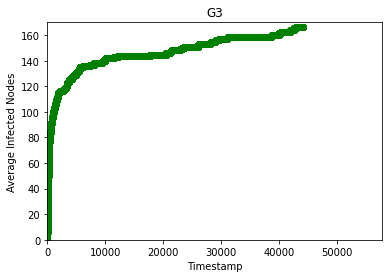

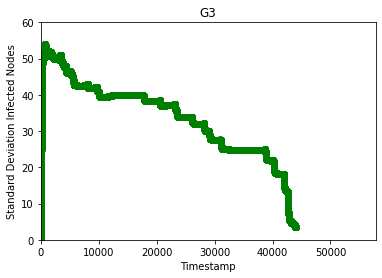

In [ ]:
plt.figure(figsize=(6, 4)) 
plt.plot(x_axis[:], dfG3_mean[:],'go-',linestyle = 'None')
plt.xlabel('Timestamp')
plt.ylabel('Average Infected Nodes')
plt.title("G3")

axes = plt.gca()
axes.set_xlim([0,57791])
axes.set_ylim([0,170])


plt.figure()
plt.plot(x_axis[:], dfG3_std[:],'go-',linestyle = 'None')
plt.xlabel('Timestamp')
plt.ylabel('Standard Deviation Infected Nodes')
plt.title("G3")

axes = plt.gca()
axes.set_xlim([0,57791])
axes.set_ylim([0,60])
